In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysing the Jacobian of the parameter landscape scan

In order to characterise the mutational properties of our RNA genetic circuits, we can look at attributes of the analytic landscape generated across a subset of parameters. The goal is to predict the *robustness of any mutation*. Because a mutation is a discrete step in sequence space, that translates to a discrete step in parameter space. Previously, we have scanned over a range of values in the parameter space, which, while continuous, is too large to scan over significantly. The calculation to find the value of an analytic given any set of parameters is also not completely trivial. There is some leeway in the requirement for the parameter landscape tobe continuous, as we are more interested in the relative analytic given a relative set of parameters than getting a particularly accurate value. For example, we may want to know whether a circuit is more sensitive if the interaction strength between node 1 is greater between node 2 than node 3. Being able to generalise in such a way is tractable with a discrete sampling of the landscape.

To summarise, these are the goals we want to achieve with analysis of the Jacobian:
1. Generalising enough to identify interactions that do not have a significant effect and can be abstracted away.

Ultimately, we want to see if we can answer some of the above questions without having to scan across the entire parameter space and just sample some circuits.

# Imports

In [58]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx

from functools import partial
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

jax.config.update('jax_platform_name', 'cpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

In [59]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.type_handling import flatten_listlike

# Load data

In [88]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
analytic_name = 'sensitivity'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if analytic_name in f][0])
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']

param_range = create_parameter_range(config['parameter_based_simulation'])
x = np.load(fn)

In [89]:
x.shape

(3, 9, 9, 9, 9, 9, 9)

In [92]:
tsne = TSNE(n_components=3, learning_rate='auto',
            init='random', perplexity=3)

X_embedded = tsne.fit_transform(x[1, :, :, :, :, 0, 0].reshape(x.shape[1]*x.shape[2],x.shape[3]*x.shape[4]))
X_embedded.shape

(81, 3)

<AxesSubplot: >

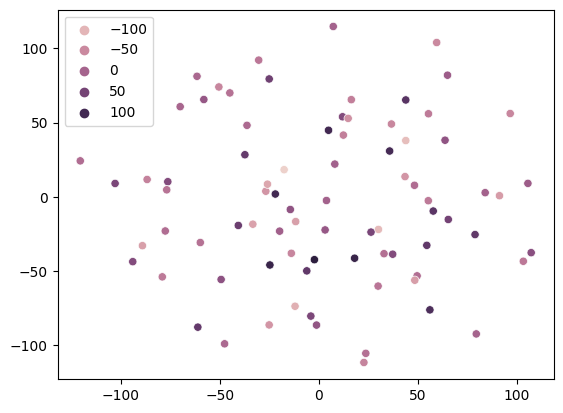

In [91]:

sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=X_embedded[:, 2],
)

In [79]:
x[1, :, :, :, 0, 0, 0].reshape(x.shape[1], x.shape[2]*x.shape[3]).shape

(9, 81)

In [61]:
stop

NameError: name 'stop' is not defined

# Set up test data

In [ ]:

from synbio_morpher.utils.modelling.deterministic import Deterministic


unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
bound_species = sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in unbound_species] for y in unbound_species])))
species = unbound_species + bound_species
signal_species = ['RNA_0']
output_species = ['RNA_1']
s_idxs = [species.index(s) for s in signal_species]
output_idxs = [species.index(s) for s in output_species]
signal_onehot = np.array([1 if s in [species.index(ss) for ss in signal_species] else 0 for s in np.arange(len(species))])
signal_target = 2
    
k = 0.00150958097
N0 = 200
y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]]).astype(np.float32)

t0 = 0
t1 = 100
ts = np.linspace(t0, t1, 500)
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10

# Reactions
rates = np.array([[1e-4, 1e-4, 1e1],
                  [1e-4, 1e-6, 1e-4],
                  [1e1, 1e-4, 1e-4]])

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
])
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# Rates
reverse_rates = rates[np.triu_indices(len(rates))]
forward_rates = np.ones_like(reverse_rates) * k

## Try jax

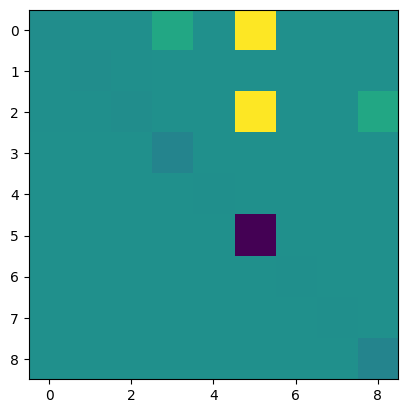

In [ ]:
from jax import jacrev


def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# bb = partial(bioreaction_sim_dfx_expanded,
#              t0=t0, t1=t1, dt0=dt0,
#              signal=None, signal_onehot=signal_onehot,
#              forward_rates=forward_rates,
#              inputs=inputs,
#              outputs=outputs,
#              solver=dfx.Tsit5(),
#              saveat=dfx.SaveAt(
#                  ts=ts),
#              max_steps=max_steps,
#              stepsize_controller=make_piecewise_stepcontrol(
#                  t0=t0, t1=t1, dt0=dt0, dt1=dt1)
#              )

Jbb = jacrev(partial(one_step_de_sim_expanded,
                     forward_rates=forward_rates,
                     inputs=inputs,
                     outputs=outputs))


rates = np.array([[1e1, 1e-4, 1e2],
                  [1e-4, 1e-1, 1e-1],
                  [1e2, 1e-1, 1e1]])
reverse_rates = rates[np.triu_indices(len(rates))]

y0 = np.array([N0] * 9).astype(np.float32)
y0 = np.array([N0, N0, N0, 1, 1, 1, 1, 1, 1]).astype(np.float32)
sol = Jbb(y0, reverse_rates=reverse_rates)
plt.imshow(sol)

In [ ]:


def one_step_de_sim_expanded(t, spec_conc, args, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def wrap(y0,
         solver=dfx.Tsit5(),
         saveat=dfx.SaveAt(
        ts=ts),
        max_steps=max_steps,
        stepsize_controller=make_piecewise_stepcontrol(
        t0=t0, t1=t1, dt0=dt0, dt1=dt1)):
    term = dfx.ODETerm(
        jacrev(partial(one_step_de_sim_expanded,
                       forward_rates=forward_rates,
                       inputs=inputs,
                       outputs=outputs,
                       reverse_rates=reverse_rates))
        # partial(bioreaction_sim_expanded,
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=None,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)
    
sol = wrap(y0)

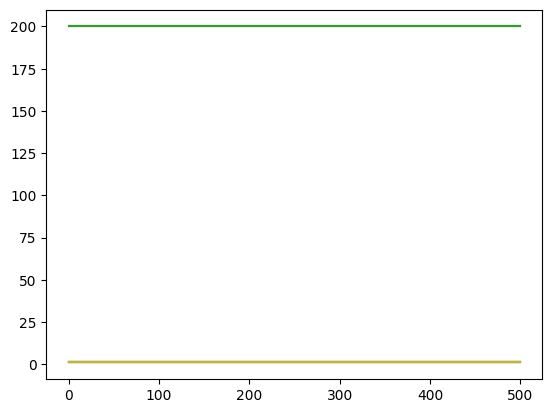

In [ ]:
plt.plot(sol.ys)

# Was the sampling good...?